In [63]:
# Imports cell

import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import scipy.stats as stats
from patsy.contrasts import Helmert
from statsmodels.formula.api import ols
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, plot_confusion_matrix
import xgboost as xgb

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 50)
sns.set_theme()

In [2]:
# Read data

df_list = []
for i in range(1, 5):
    df = pd.read_spss(f"./Study_{i}/dataset.sav")
    if i == 1 or i == 4:
        df["social_network"] = "facebook"
    elif i == 2:
        df["social_network"] = "twitter"
    elif i == 3:
        df["social_network"] = "instagram"
    columns = list(df.columns)
    df.columns = range(len(columns))
    df_list.append(df)

In [3]:
# Selected columns for the study

selected_columns = [
    "gender",
    "country",
    "education",
    "age",
    "age_group",
    "occupation",
    "Politics",
    "Fbook",
    "shared_found_later",
    "shared_while_knowing",
    "SC0",
    "SC1",
    "SC2",
    "Authoritative",
    "Consensus",
    "Openness",
    "Neuroticism",
    "Extraversion",
    "Conscientiousness",
    "Agreeableness",
    "Social",
    "Economic",
    "Functional_Consumption",
    "Critical_Consumption",
    "Functional_Prosumption",
    "Critical_Prosumption",
    "social_network"
]

In [4]:
# Filter on these columns

df = pd.concat(df_list, axis=0)
df.columns = columns
df = df[selected_columns]

In [6]:
# Dataframe overview

df.head(1)

gender                                            country        education  \
0   Male  United Kingdom of Great Britain and Northern I...  Master's Degree   

   age age_group                       occupation Politics             Fbook  \
0  NaN       NaN  Unemployed but looking for work   Centre  About once a day   

  shared_found_later shared_while_knowing  SC0  SC1  SC2 Authoritative  \
0                 No                   No  9.0  9.0  9.0        Higher   

  Consensus  Openness  Neuroticism  Extraversion  Conscientiousness  \
0     Lower      31.0         18.0          33.0               41.0   

   Agreeableness  Social  Economic  Functional_Consumption  \
0           27.0   400.0      70.0                    31.0   

   Critical_Consumption  Functional_Prosumption  Critical_Prosumption  \
0                  50.0                    32.0                  44.0   

  social_network  
0       facebook

In [7]:
# Missing data and patterns

print(df.isna().sum())
print(df.dropna().shape[0] / df.shape[0])
df.dropna(inplace=True)

gender                     0
country                    0
education                  1
age                        5
age_group                  5
occupation                 1
Politics                   4
Fbook                      0
shared_found_later         0
shared_while_knowing       0
SC0                        0
SC1                        0
SC2                        0
Authoritative              0
Consensus                  0
Openness                   5
Neuroticism                5
Extraversion               6
Conscientiousness          7
Agreeableness              6
Social                     2
Economic                   1
Functional_Consumption     2
Critical_Consumption      18
Functional_Prosumption    17
Critical_Prosumption      20
social_network             0
dtype: int64
0.9791192103264996


In [8]:
df.shape

(2579, 27)

Only a few samples missing. 
When age is missing, age group is missing too (makes sense). 
Some answers are missing: simply deleting rows with missing data will result in a loss of 2% of the dataset, which is low enough to allow us to do it.

# What are the target variables ?

- SC0: likelihood of sharing disinformation items
- SC1: ability to recognize disinformation items
- SC2: have they seen the shown disinformation pieces before?

<AxesSubplot:>

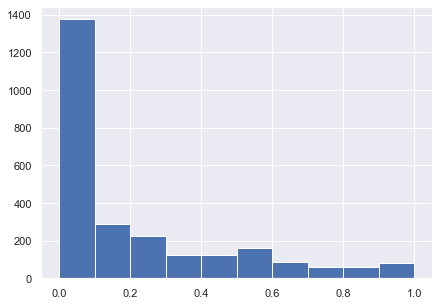

In [9]:
# Distribution of the likelihood of sharing disinformation

plt.figure(figsize=(7, 5))
((df["SC0"] - 3)/(33 - 3)).hist()

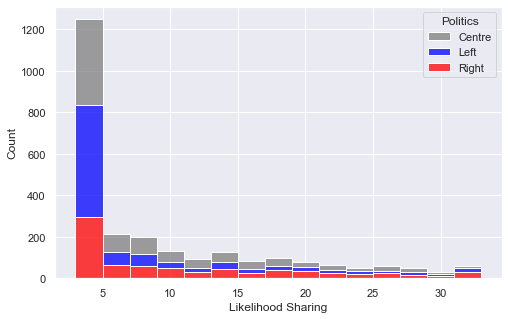

In [10]:
sns.set_theme(style="whitegrid")
sns.set_theme()
plt.figure(figsize=(8, 5))
sns.histplot(data=df.reset_index(), x="SC0", hue="Politics", multiple="stack",
            palette=["grey", "blue", "red"], bins=15)
plt.xlabel("Likelihood Sharing")
plt.ylabel("Count")
plt.savefig("./img/left_right_centre.pdf")

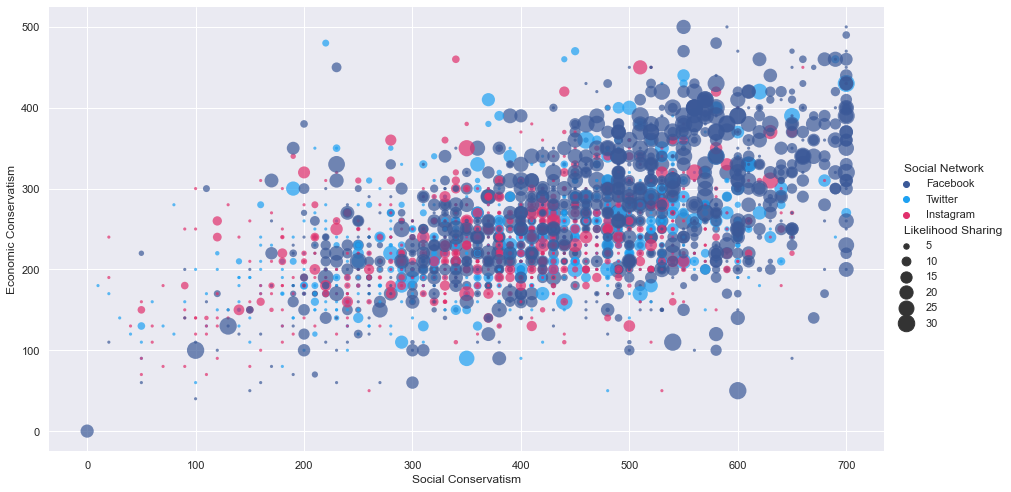

In [11]:
dff = df.copy()
dff.rename(columns={'social_network':'Social Network',
                    'SC0': 'Likelihood Sharing',
                    'Economic':'Economic Conservatism',
                    'Social':'Social Conservatism'}, inplace=True)
dff["Social Network"] = dff["Social Network"].replace({"facebook":"Facebook",
                               "twitter":"Twitter",
                               "instagram":"Instagram"})
g = sns.relplot(
    data=dff[((dff["gender"] == "Female") | (dff["gender"] == "Male"))].reset_index(),
    x="Social Conservatism", y="Economic Conservatism", alpha=0.7,
    hue="Social Network", size="Likelihood Sharing", aspect=1.8, s=10,
    sizes=(10, 300), height=7, palette=["#3b5998", "#1DA1F2", "#E1306C"],
    linewidth=0
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.savefig("./img/conservatism.pdf")

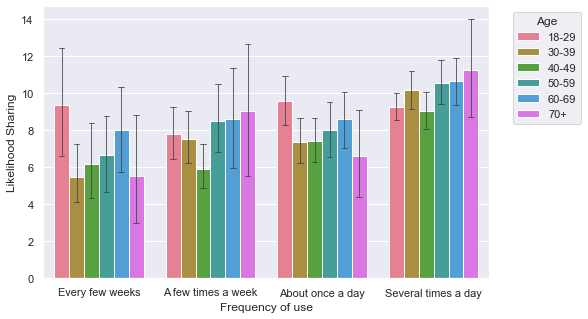

In [12]:
plt.figure(figsize=(8, 5))
g = sns.barplot(x="Fbook", y="SC0", hue="age_group", order=["Every few weeks", 
                                                        "A few times a week", 
                                                        "About once a day", 
                                                        "Several times a day"], 
            data=df, ci=95, palette=sns.color_palette("husl", 6), errwidth=0.8, capsize=0.05,
            estimator=np.mean)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="Age")
plt.xlabel("Frequency of use")
plt.ylabel("Likelihood Sharing")
plt.savefig("./img/frequency.pdf", bbox_extra_artists=(g,), bbox_inches='tight')

In [13]:
df.drop("age_group", axis=1, inplace=True)

# Transform features into numerical

In [14]:
# Gender
# One-hot encoding

df["gender"] = df["gender"].replace({"Other": "Other/PNTS", "PNTS": "Other/PNTS"})
gender_copy = df["gender"] # Will be used later
df = pd.concat([df.drop("gender", axis=1), pd.get_dummies(df["gender"])], axis=1)

In [15]:
# Country
# One-hot encoding

df["country"] = df["country"].replace({"United Kingdom of Great Britain and Northern Ireland": "UK",
                                       "United States of America": "US"})
df = pd.concat([df.drop("country", axis=1), pd.get_dummies(df["country"])[["UK"]]], axis=1)

In [16]:
# Education
# Hierarchical ranking (longest studies)

df["education"] = df["education"].replace({"Less than High School": 1,
                                           "High School / Secondary School": 2,
                                           "Some College or University": 3,
                                           "College or University Degree": 4,
                                           "Master's Degree": 5,
                                           "Doctoral Degree": 6,
                                           "Professional Degree (JD, MD)": 7})

In [17]:
# Occupation
# Convert into binary: employed or not

df["occupation"] = df["occupation"].replace({"Employed for wages": 1,
                                             "Self-employed": 1,
                                             "Retired": 0,
                                             "Student": 0,
                                             "Home-maker": 0,
                                             "Unemployed but looking for work": 0,
                                             "Unable to work for health or other reasons": 0})
df.rename(columns={"occupation": "employed"}, inplace=True)

In [18]:
# Politics
# One-hot encoding

df = pd.concat([df.drop("Politics", axis=1), pd.get_dummies(df["Politics"])], axis=1)

In [19]:
# Social networks use
# Hierarchical ranking (the higher the more frequent)

df["Fbook"] = df["Fbook"].replace({"Every few weeks": 1,
                                   "A few times a week": 2,
                                   "About once a day": 3,
                                   "Several times a day": 4})
df.rename(columns={"Fbook": "use_frequency"}, inplace=True)

In [20]:
# Accidentaly shared a fake news

df["shared_found_later"] = df["shared_found_later"].replace({"No": 0, "Yes": 1})

In [21]:
# Deliberate sharing

df["shared_while_knowing"] = df["shared_while_knowing"].replace({"No": 0, "Yes": 1})

In [22]:
# Likelihood of sharing disinformation

df.rename(columns={"SC0": "likelihood_disinformation"}, inplace=True)

# Likelihood of recognizing truth/fake

df.rename(columns={"SC1": "likelihood_truth"}, inplace=True)

# Likelihood of sharing seen before disinformation

df.rename(columns={"SC2": "likelihood_seen_before"}, inplace=True)

In [23]:
# Relation to authority (reliable sources or not)

df["Authoritative"] = df["Authoritative"].replace({"Lower": 0,
                                                   "Higher": 1})

In [24]:
# Relation to consensus (a lot of people agree/disagree)

df["Consensus"] = df["Consensus"].replace({"Lower": 0,
                                           "Higher": 1})

In [25]:
# Social network used

df = pd.concat([df.drop("social_network", axis=1), pd.get_dummies(df["social_network"])], axis=1)

# Difference in likelihoods of sharing disinformation between genders

In [26]:
# Difference in mean hypothesis testing

n1 = df[df["Male"] == 1].shape[0]
mu1 = df[df["Male"] == 1]["likelihood_disinformation"].mean()
s1 = df[df["Male"] == 1]["likelihood_disinformation"].std()
n2 = df[df["Female"] == 1].shape[0]
mu2 = df[df["Female"] == 1]["likelihood_disinformation"].mean()
s2 = df[df["Female"] == 1]["likelihood_disinformation"].std()

degrees_freedom = (s1**2 / n1 + s2**2 / n2)**2 / ((s1**2 / n1)**2 / (n1 - 1) + (s2**2 / n2)**2 / (n2 - 1))
# 2157 => consider a N(0, 1) is equivalent

t = ((mu1 - mu2) - 0) / np.sqrt(s1**2 / n1 + s2**2 / n2)

p_value = 2 * scipy.stats.t.cdf(df=2157, x=-t)

print(f"Test statistic: {t}")
print(f"p-value: {p_value}")

Test statistic: 7.585792790504687
p-value: 4.881616414562726e-14


Conclusion: the p-value is low enough to show evidence to reject $H_0$, which therefore means that the two means are signficantly different

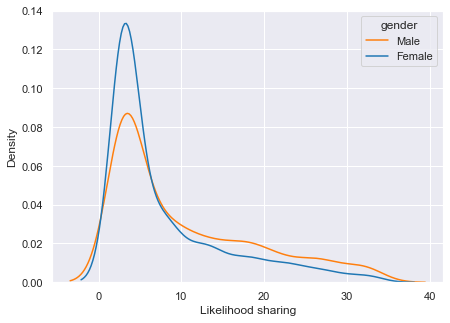

In [27]:
# Comparison with densities

plt.figure(figsize=(7, 5))
sns.kdeplot(df[df["Male"] == 1]["likelihood_disinformation"].values, color="#ff7f0e", label="Male")
sns.kdeplot(df[df["Female"] == 1]["likelihood_disinformation"].values, color="#1f77b4", label="Female")
plt.legend(title="gender")
plt.xlabel("Likelihood sharing")
plt.savefig("./img/density_ls.pdf")

In [28]:
# Linear model

data = pd.concat([gender_copy, df["likelihood_disinformation"]], axis=1)
levels = ["Other/PNTS", "Male", "Female"]
contrast = Helmert().code_without_intercept(levels)
mod = ols("likelihood_disinformation ~ C(gender, contrast)", data=data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     likelihood_disinformation   R-squared:                       0.024
Model:                                   OLS   Adj. R-squared:                  0.023
Method:                        Least Squares   F-statistic:                     31.40
Date:                       Sun, 24 Apr 2022   Prob (F-statistic):           3.35e-14
Time:                               18:46:42   Log-Likelihood:                -9006.0
No. Observations:                       2579   AIC:                         1.802e+04
Df Residuals:                           2576   BIC:                         1.804e+04
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         7.7410      0.890      8.697      0.000       5.996       9.486
C(gender, contrast)[H.Male]       1.2303      0.158      7.772      0.000       0.920       1.541
C(gender, contrast)[H.Female]    -1.4261      0.885     -1.611      0.107      -3.162       0.310
==============================================================================
Omnibus:                      478.282   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              778.135
Skew:                           1.295   Prob(JB):                    1.07e-169
Kurtosis:                       3.729   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\beta_1 = 7.7410$ (intercept)
$\beta_2 = 1.2303 = \frac{\mu_{Male} - \mu_{Other}}{2}$ 
$\beta_3 = -1.4261 = \frac{1}{3} (\mu_{Female} - \frac{\mu_{Male} + \mu_{Other}}{2}) $ 

In [30]:
# ANOVA

model = ols("likelihood_disinformation ~ C(gender)", data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq      df          F        PR(>F)
C(gender)    3973.674248     2.0  31.403566  3.351303e-14
Residual   162978.063635  2576.0        NaN           NaN

Two eventualities come up: either men are more likely to trust things they see on the internet, or they share them more easily than women.

# Difference in trusting disinformation content

In [31]:
# Difference in mean hypothesis testing

n1 = df[df["Male"] == 1].shape[0]
mu1 = df[df["Male"] == 1]["likelihood_truth"].mean()
s1 = df[df["Male"] == 1]["likelihood_truth"].std()
n2 = df[df["Female"] == 1].shape[0]
mu2 = df[df["Female"] == 1]["likelihood_truth"].mean()
s2 = df[df["Female"] == 1]["likelihood_truth"].std()

degrees_freedom = (s1**2 / n1 + s2**2 / n2)**2 / ((s1**2 / n1)**2 / (n1 - 1) + (s2**2 / n2)**2 / (n2 - 1))
# 2157 => consider a N(0, 1) is equivalent

t = ((mu1 - mu2) - 0) / np.sqrt(s1**2 / n1 + s2**2 / n2)

p_value = 2 * scipy.stats.norm.cdf(-t)

print(f"Test statistic: {t}")
print(f"p-value: {p_value}")

Test statistic: 5.336563060332859
p-value: 9.47249374948668e-08


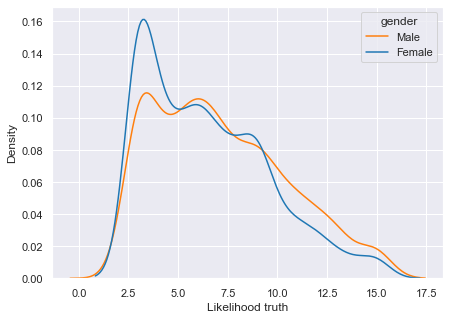

In [32]:
# Comparison with densities

plt.figure(figsize=(7, 5))
sns.kdeplot(df[df["Male"] == 1]["likelihood_truth"].values, color="#ff7f0e", label="Male")
sns.kdeplot(df[df["Female"] == 1]["likelihood_truth"].values, color="#1f77b4", label="Female")
plt.legend(title="gender")
plt.xlabel("Likelihood truth")
plt.savefig("./img/density_lt.pdf")

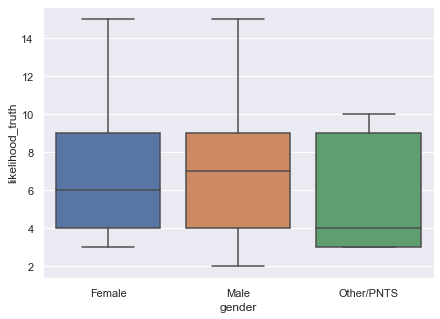

sum_sq      df          F        PR(>F)
C(gender)    302.193052     2.0  14.818544  3.991424e-07
Residual   26266.052780  2576.0        NaN           NaN

In [33]:
# ANOVA

data = pd.concat([gender_copy, df["likelihood_truth"]], axis=1)

plt.figure(figsize=(7, 5))
ax = sns.boxplot(x="gender", y="likelihood_truth", data=data)
plt.show()

model = ols("likelihood_truth ~ C(gender)", data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

In [34]:
data = pd.concat([data, df["likelihood_disinformation"], df["age"]], axis=1)

In [35]:
fig = go.Figure()
fig.add_trace(go.Histogram2dContour(
        x = data[data["gender"] == "Male"]["likelihood_truth"],
        y = data[data["gender"] == "Male"]["likelihood_disinformation"],
        colorscale = 'Blues',
        reversescale = True,
        xaxis = 'x',
        yaxis = 'y'
    ))
fig.add_trace(go.Scatter(
        x = data[data["gender"] == "Male"]["likelihood_truth"],
        y = data[data["gender"] == "Male"]["likelihood_disinformation"],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'rgba(0,0,0,0.3)',
            size = 3
        )
    ))
fig.add_trace(go.Histogram(
        y = data[data["gender"] == "Male"]["likelihood_disinformation"],
        xaxis = 'x2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    ))
fig.add_trace(go.Histogram(
        x = data["likelihood_truth"],
        yaxis = 'y2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    ))

fig.update_layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 500,
    width = 600,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False,
    xaxis_title = "Trust in disinformation",
    yaxis_title = "Likelihood of sharing",
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0
    )
)

fig.show()
fig.write_image("./img/hist_2d_male.pdf")

In [36]:
fig = go.Figure()
fig.add_trace(go.Histogram2dContour(
        x = data[data["gender"] == "Female"]["likelihood_truth"],
        y = data[data["gender"] == "Female"]["likelihood_disinformation"],
        colorscale = 'Blues',
        reversescale = True,
        xaxis = 'x',
        yaxis = 'y'
    ))
fig.add_trace(go.Scatter(
        x = data[data["gender"] == "Female"]["likelihood_truth"],
        y = data[data["gender"] == "Female"]["likelihood_disinformation"],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'rgba(0,0,0,0.3)',
            size = 3
        )
    ))
fig.add_trace(go.Histogram(
        y = data[data["gender"] == "Female"]["likelihood_disinformation"],
        xaxis = 'x2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    ))
fig.add_trace(go.Histogram(
        x = data["likelihood_truth"],
        yaxis = 'y2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    ))

fig.update_layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 500,
    width = 600,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False,
    xaxis_title = "Trust in disinformation",
    yaxis_title = "Likelihood of sharing",
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=0
    )
)

fig.show()
fig.write_image("./img/hist_2d_female.pdf")

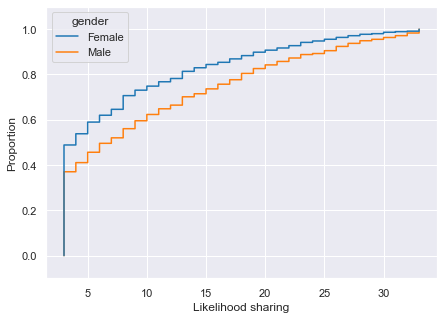

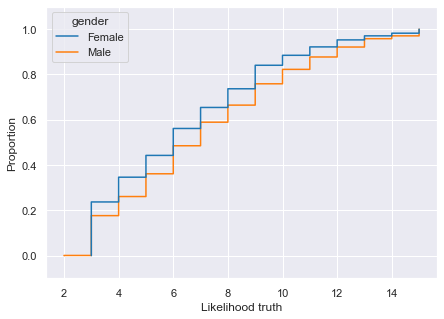

KstestResult(statistic=0.14599109303006488, pvalue=3.329891917758232e-12)
KstestResult(statistic=0.08540520549211779, pvalue=0.0001846241205967214)


In [37]:
# Two-sample KS test

data = data[data["gender"] != "Other/PNTS"]
data.reset_index(drop=True, inplace=True)

plt.figure(figsize=(7, 5))
sns.ecdfplot(data=data, x="likelihood_disinformation", hue="gender", palette=["#1f77b4", "#ff7f0e"])
plt.ylim(-0.1, 1.1)
plt.xlabel("Likelihood sharing")
plt.savefig("./img/ecdf_ls.pdf")
plt.show()

plt.figure(figsize=(7, 5))
sns.ecdfplot(data=data, x="likelihood_truth", hue="gender", palette=["#1f77b4", "#ff7f0e"])
plt.ylim(-0.1, 1.1)
plt.xlabel("Likelihood truth")
plt.savefig("./img/ecdf_lt.pdf")
plt.show()

print(stats.ks_2samp(data[data["gender"] == "Male"]["likelihood_disinformation"], 
               data[data["gender"] == "Female"]["likelihood_disinformation"]))

print(stats.ks_2samp(data[data["gender"] == "Male"]["likelihood_truth"], 
               data[data["gender"] == "Female"]["likelihood_truth"]))

# Modelling the likelihood of sharing disinformation from features

<AxesSubplot:>

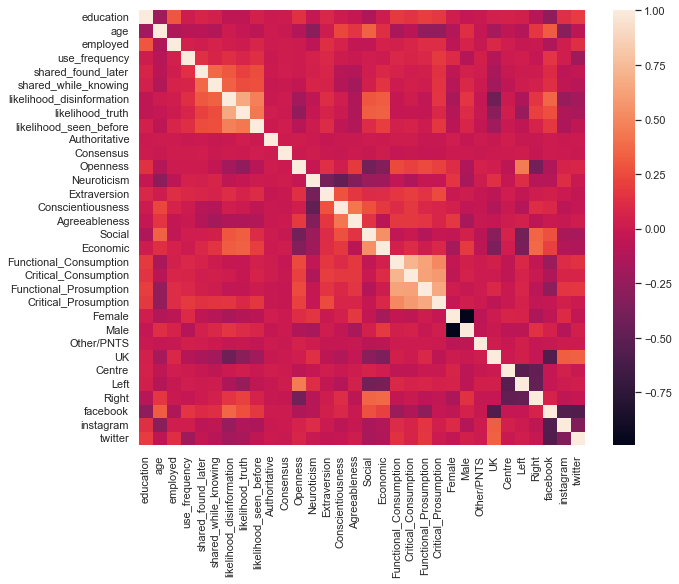

In [38]:
# Correlation heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr())

In [39]:
dff = df.copy()
dff.columns = [
    "Education",
    "Age",
    "Employed",
    "Frequency of use",
    "Shared (found later)",
    "Shared (while knowing)",
    "Likelihood sharing",
    "Likelihood trust",
    "Likelihood seen before",
    "Authoritative",
    "Consensus",
    'Openness',
    'Neuroticism', 
    'Extraversion', 
    'Conscientiousness', 
    'Agreeableness',
    'Social Conservatism', 
    'Economic Conservatism', 
    'Functional Consumption', 
    'Critical Consumption',
    'Functional Prosumption', 
    'Critical Prosumption',
    'Female',
    'Male',
    'Other/PNTS',
    'UK',
    'Centre',
    'Left',
    'Right',
    'Facebook',
    'Instagram',
    'Twitter'
]
dff.drop(["Male", "Other/PNTS", "Centre", "Instagram"], axis=1, inplace=True)

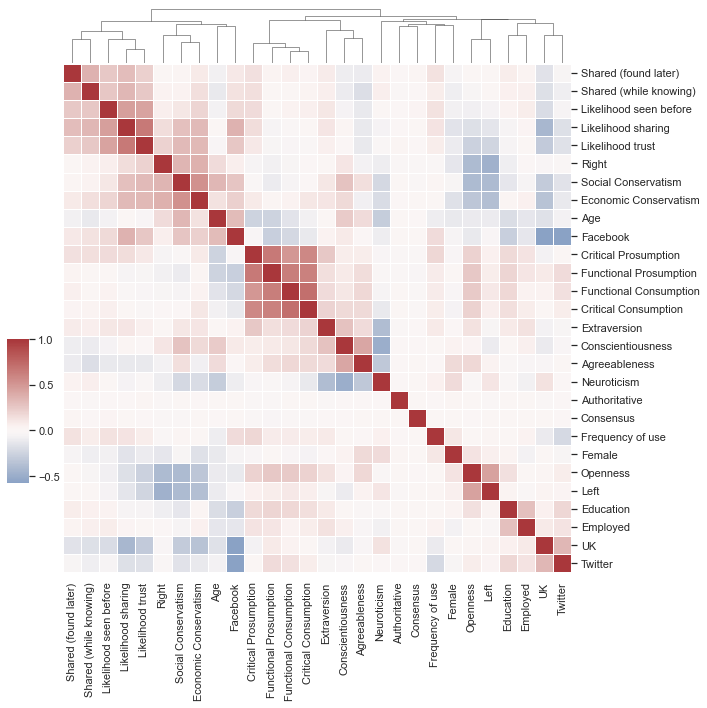

In [40]:
# Draw the full plot
g = sns.clustermap(dff.corr(), center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .1),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(10, 10))

g.ax_row_dendrogram.remove()
plt.savefig("./img/corr.pdf")

In [41]:
#X = df.drop(["likelihood_disinformation", "likelihood_truth", "likelihood_seen_before",
#             "Other/PNTS"], axis=1) # We can remove Other/PNTS since the information is already contained in Male/Female
X = df.drop(["likelihood_disinformation", "Male", "Other/PNTS", "Centre", "instagram"], axis=1)
y = df["likelihood_disinformation"].values

# Scale the likelihood between 0 and 1
y = (y - 3) / (33 - 3)

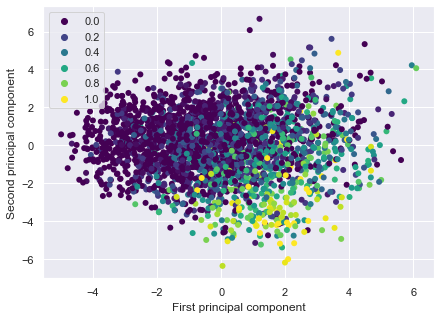

In [42]:
# Low dimension visualisation

X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA().fit_transform(X_scaled)

plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="viridis", linewidth=0)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig("./img/pca.pdf")

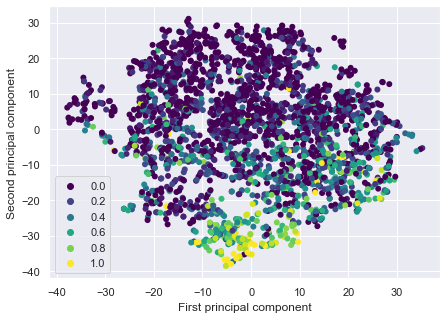

In [43]:
# t-Sne

X_tsne = TSNE(n_components=3, perplexity=10, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette="viridis", linewidth=0)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.savefig("./img/tsne.pdf")

In [44]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling according to train set

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Transform them into pandas data frames

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

### First, let's try a linear regression

In [45]:
linear_regression = sm.OLS(y_train, sm.add_constant(X_train))
results = linear_regression.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     101.4
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:49:58   Log-Likelihood:                 640.99
No. Observations:                2063   AIC:                            -1226.
Df Residuals:                    2035   BIC:                            -1068.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.2020      0.004     51.387      0.000       0.194       0.210
education                 -0.0080      0.004     -1.809      0.071      -0.017       0.001
age                       -0.0085      0.005     -1.722      0.085      -0.018       0.001
employed                   0.0081      0.004      1.920      0.055      -0.000       0.016
use_frequency              0.0027      0.004      0.634      0.526      -0.006       0.011
shared_found_later         0.0283      0.004      6.465      0.000       0.020       0.037
shared_while_knowing       0.0224      0.004      4.986      0.000       0.014       0.031
likelihood_truth           0.1190      0.005     24.182      0.000       0.109       0.129
likelihood_seen_before     0.0367      0.005      7.964      0.000       0.028       0.046
Authoritative             -0.0032      0.004     -0.799      0.424      -0.011       0.005
Consensus                 -0.0022      0.004     -0.550      0.582      -0.010       0.006
Openness                  -0.0052      0.005     -1.027      0.305      -0.015       0.005
Neuroticism               -0.0025      0.005     -0.485      0.628      -0.012       0.008
Extraversion               0.0112      0.005      2.469      0.014       0.002       0.020
Conscientiousness          0.0054      0.005      1.082      0.280      -0.004       0.015
Agreeableness             -0.0076      0.005     -1.605      0.109      -0.017       0.002
Social                     0.0116      0.006      2.078      0.038       0.001       0.022
Economic                   0.0030      0.005      0.562      0.574      -0.008       0.014
Functional_Consumption    -0.0132      0.006     -2.144      0.032      -0.025      -0.001
Critical_Consumption       0.0101      0.006      1.611      0.107      -0.002       0.022
Functional_Prosumption    -0.0055      0.006     -0.875      0.382      -0.018       0.007
Critical_Prosumption       0.0168      0.006      2.809      0.005       0.005       0.029
Female                    -0.0151      0.004     -3.507      0.000      -0.024      -0.007
UK                        -0.0491      0.005     -9.176      0.000      -0.060      -0.039
Left                       0.0066      0.005      1.328      0.184      -0.003       0.016
Right                      0.0066      0.005      1.374      0.169      -0.003       0.016
facebook                   0.0296      0.006      4.724      0.000       0.017       0.042
twitter                    0.0157      0.005      3.141      0.002       0.006       0.026
==============================================================================
Omnibus:                      155.312   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              295.418
Skew:                    

In [46]:
# Build the Latex table

def give_confidence(x):
    if (x >= 0) & (x < 0.001):
        return "***"
    elif (x > 0.001) & (x < 0.01):
        return "**"
    elif (x > 0.01) & (x < 0.05):
        return "*"
    elif (x > 0.05) & (x < 0.1):
        return "."
    elif (x > 0.1) & (x <= 1):
        return " "

estimates = results.params
effects = np.sign(estimates).replace({1.0: "+", -1.0: "-"})
pvalues = results.pvalues
confidence = pvalues.apply(give_confidence)

summary = pd.concat([estimates, effects, pvalues, confidence], axis=1).round(4)
summary.columns = ["Estimate", "Effect", "p-value", "Significance"]
summary.index = [
    "Intercept",
    "Education",
    "Age",
    "Employed",
    "Frequency of use",
    "Shared (found later)",
    "Shared (while knowing)",
    "Likelihood truth",
    "Likelihood seen before",
    "Authoritative",
    "Consensus",
    "Openness",
    "Neuroticism",
    "Extraversion",
    "Conscientiousness",
    "Agreeableness",
    "Social", 
    "Economic",
    "Functional Consumption",
    "Critical Consumption",
    "Functional Prosumption",
    "Critical Prosumption",
    "Female",
    "UK",
    "Left",
    "Right",
    "Facebook",
    "Twitter"
]

MSE on train set: 0.03145201446904482
MSE on test set: 0.03001065870097148


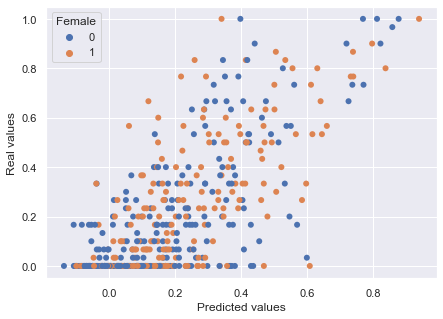

In [48]:
# Evaluate performance

preds = results.predict(sm.add_constant(X_test, has_constant="add")).values
print(f"MSE on train set: {mean_squared_error(y_pred=results.fittedvalues, y_true=y_train)}")
print(f"MSE on test set: {mean_squared_error(y_pred=preds, y_true=y_test)}")

plt.figure(figsize=(7, 5))
sns.scatterplot(x=preds, y=y_test, hue=(X_test["Female"] < 0).astype(int), linewidth=0)
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.savefig("./img/men_women_residuals.pdf")

In [49]:
print(((preds[X_test["Female"] > 0] - y_test[X_test["Female"] > 0])**2).mean())
print(((preds[X_test["Female"] < 0] - y_test[X_test["Female"] < 0])**2).mean())

0.027820387443371414
0.03286583373320014


In [50]:
print(r2_score(y_test[X_test["Female"] > 0], preds[X_test["Female"] > 0]))
print(r2_score(y_test[X_test["Female"] < 0], preds[X_test["Female"] < 0]))

0.5394238880184961
0.5149330817446489


### Some features do not have a lot of importance, use LASSO

In [51]:
alphas = np.linspace(1e-6, 1e-2, 100)
mse = []

for alpha in alphas:
    kf = KFold(n_splits=3, random_state=42, shuffle=True)
    mse_fold = []
    for train_index, test_index in kf.split(X_train.values):
        train, test = X_train.values[train_index], X_train.values[test_index]
        train_targets, test_targets = y_train[train_index], y_train[test_index]
        lasso_regression = sm.OLS(train_targets, sm.add_constant(train))
        results = lasso_regression.fit_regularized(method="elastic_net", L1_wt=1.0, alpha=alpha)
        preds = results.predict(sm.add_constant(test, has_constant="add"))
        mse_fold.append(mean_squared_error(y_pred=preds, y_true=test_targets))
    mse.append(np.mean(mse_fold))

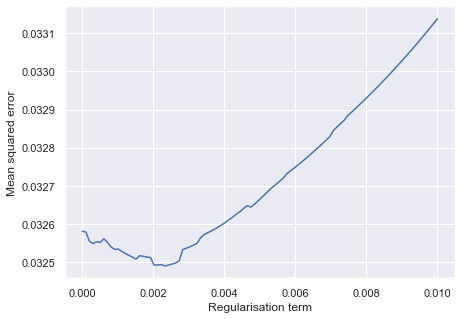

In [52]:
plt.figure(figsize=(7, 5))
sns.lineplot(x=alphas, y=mse)
plt.xlabel("Regularisation term")
plt.ylabel("Mean squared error")
plt.savefig("./img/lasso.pdf")

In [53]:
alpha_opt = alphas[mse == min(mse)][0]

lasso_regression = sm.OLS(y_train, sm.add_constant(X_train))
results = lasso_regression.fit_regularized(method="elastic_net", L1_wt=1.0, alpha=alpha_opt)
lasso_results = results.params
lasso_results.index = summary.index
lasso_results

Intercept                 0.199696
Education                -0.005001
Age                       0.000000
Employed                  0.006575
Frequency of use          0.000312
Shared (found later)      0.026490
Shared (while knowing)    0.022781
Likelihood truth          0.119907
Likelihood seen before    0.037295
Authoritative            -0.001008
Consensus                 0.000000
Openness                  0.000000
Neuroticism               0.000000
Extraversion              0.010164
Conscientiousness         0.002532
Agreeableness            -0.005021
Social                    0.009646
Economic                  0.005144
Functional Consumption   -0.006330
Critical Consumption      0.001320
Functional Prosumption    0.000000
Critical Prosumption      0.014110
Female                   -0.014128
UK                       -0.046615
Left                      0.000000
Right                     0.000000
Facebook                  0.025992
Twitter                   0.008311
dtype: float64

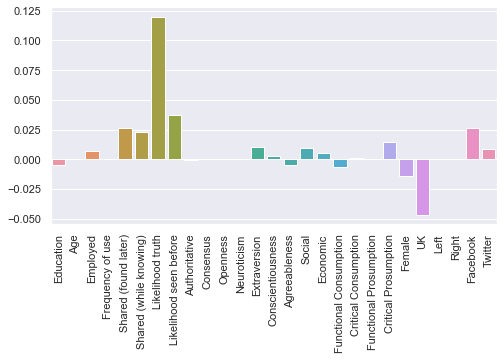

In [54]:
plt.figure(figsize=(8, 4))
features = list(dict(lasso_results).keys())[1:]
importance = list(dict(lasso_results).values())[1:]
plt.xticks(rotation=90)
sns.barplot(x=features, y=importance)
plt.savefig("./img/feature_importance.pdf", bbox_inches="tight")

In [55]:
selected = list(results.params[results.params != 0].index)

if selected[0] == "const":
    selected.pop(0)
    
selected

['education',
 'employed',
 'use_frequency',
 'shared_found_later',
 'shared_while_knowing',
 'likelihood_truth',
 'likelihood_seen_before',
 'Authoritative',
 'Extraversion',
 'Conscientiousness',
 'Agreeableness',
 'Social',
 'Economic',
 'Functional_Consumption',
 'Critical_Consumption',
 'Critical_Prosumption',
 'Female',
 'UK',
 'facebook',
 'twitter']

### Transform the regression problem into classification + regression (or just classification)

In [56]:
(y >= 0.15).mean()

0.4079100426521908

In [57]:
y_class = (y >= 0.15).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Scaling according to train set

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Transform them into pandas data frames

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [74]:
params = {
    'min_child_weight': [1, 5],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1]
}

clf = xgb.XGBClassifier(n_estimators=600, objective="binary:logistic", 
                        use_label_encoder=False, eval_metric="error")

grid = GridSearchCV(clf, param_grid=params, verbose=False, scoring="accuracy")

grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [971]:
grid.best_params_, grid.best_score_

({'colsample_bytree': 0.6,
  'gamma': 1.5,
  'learning_rate': 0.01,
  'max_depth': 5,
  'min_child_weight': 1,
  'subsample': 0.6},
 0.7736430099438163)

In [59]:
model = xgb.XGBClassifier(n_estimators=600, objective="binary:logistic", use_label_encoder=False,
                          colsample_bytree=0.6, gamma=1.5, learning_rate=0.01, max_depth=5, min_child_weight=1,
                          subsample=0.6)

model.fit(X_train, y_train)

model.score(X_test, y_test)

[18:50:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7848837209302325

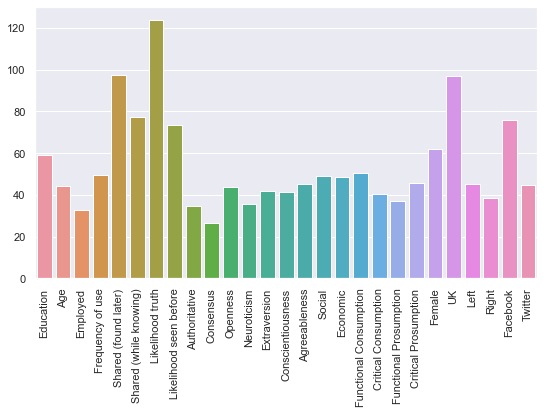

In [60]:
plt.figure(figsize=(9, 5))
features = list(dict(lasso_results).keys())[1:]
importance = list(model.get_booster().get_score(importance_type="cover").values())
plt.xticks(rotation=90)
sns.barplot(x=features, y=importance)
plt.savefig("./img/feature_importance.pdf", bbox_inches="tight")

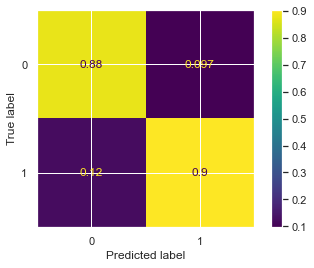

In [61]:
plot_confusion_matrix(model, X_train, y_train, normalize="pred")